In [1]:
import os
import pandas as pd

# Paths
data_dir = 'Classification_Combined_Data/Combined_S1S2_clean'
os.makedirs('Classification_Combined_Data', exist_ok=True)

# Train/test splits
# train_ids = ['S1_P13', 'S1_P04', 'S1_P27', 'S2_P24', 'S1_P18', 'S2_P45', 'S1_P23', 'S2_P15', 'S1_P11', 'S1_P29', 
#              'S2_P30', 'S2_P35', 'S1_P33', 'S2_P29', 'S1_P21', 'S1_P20', 'S2_P04', 'S1_P16', 'S2_P17', 'S2_P19',
#              'S1_P34', 'S2_P44', 'S1_P12', 'S2_P27', 'S1_P08', 'S1_P03', 'S1_P14', 'S2_P42', 'S2_P31', 'S2_P21',
#              'S1_P32', 'S2_P18', 'S2_P46', 'S2_P37', 'S2_P28', 'S2_P36', 'S2_P38', 'S1_P24', 'S2_P32', 'S1_P26',
#              'S1_P28', 'S2_P26', 'S2_P33', 'S2_P23', 'S2_P43', 'S2_P34', 'S1_P07', 'S1_P05', 'S1_P17', 'S1_P09',
#              'S2_P09']

# test_ids = ['S2_P12', 'S1_P15', 'S1_P31', 'S2_P22', 'S1_P19', 'S2_P39', 'S2_P48', 'S1_P35', 'S2_P40', 'S2_P41',
#             'S2_P49', 'S1_P10', 'S2_P13']

train_ids= ['S1_P13', 'S1_P04', 'S1_P27', 'S2_P24', 'S1_P18', 'S2_P45', 'S1_P23',
'S2_P15', 'S1_P11', 'S1_P29', 'S2_P30', 'S2_P35', 'S1_P33', 'S2_P29', 'S1_P21', 'S1_P20',
#'S2_P04', #labels missing
'S1_P16', 'S2_P17', 'S2_P19', 'S1_P34', 'S2_P44', 'S1_P12', 'S2_P27', 'S1_P08', 'S1_P03',
'S1_P14', 'S2_P42', 'S2_P31', 'S2_P21', 'S1_P32', 'S2_P18', 'S2_P46', 'S2_P37',
'S2_P28', 'S2_P36', 'S2_P38', 'S1_P24', 'S2_P32', 'S1_P26', 'S1_P28', 'S2_P26', 'S2_P33', #'S2_P23', #labels missing
'S2_P43', 'S2_P34', 'S1_P07', 'S1_P05', 'S1_P17', 'S1_P09', 'S2_P09']
 
test_ids = ['S2_P12', 'S1_P15', 'S1_P31',
#'S2_P22', ## labels missing
'S1_P19', 'S2_P39', 'S2_P48', 'S1_P35', 'S2_P40',
'S2_P41', 'S2_P49', 'S1_P10', 'S2_P13']

# Features setup
selected_features = [
    'ID','Label_unify','UNIX',  # no 'Study' column in data
    'EAR_mean', 'MAR_inner', 'MAR_outer',
    'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r',
    'pose_Tx', 'pose_Ty', 'pose_Tz',
    'pose_Rx', 'pose_Ry', 'pose_Rz',
    'gaze_angle_x', 'gaze_angle_y',
    'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'
]
exclude_features = {'ID', 'UNIX', 'Label_unify'}

def process_file(file_path, file_id):
    df = pd.read_csv(file_path)

    print(f"\n🔍 Processing: {file_id}")

    # Step 1: Select usable features
    available_features = [col for col in selected_features if col in df.columns]
    df = df[available_features]
    print(f"✅ Available features: {available_features}")
    print(f"🧮 Rows after filter: {df.shape[0]}")

    if df.empty:
        return []

    # Step 2: Overlapping 30s windows with 15s stride
    results = []
    stride = 15
    window_size = 30
    start_time = df['UNIX'].min()
    end_time = df['UNIX'].max()
    current_start = start_time

    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        group = df[(df['UNIX'] >= current_start) & (df['UNIX'] < window_end)]

        if group.shape[0] < 250:
            current_start += stride
            continue

        # Get label only if the window has a single consistent label
        if 'Label_unify' in group and group['Label_unify'].notna().any():
            unique_labels = group['Label_unify'].dropna().unique()
            if len(unique_labels) == 1:
                label = unique_labels[0]  # all rows share the same label
            else:
                current_start += stride  # skip this window entirely
                continue
        else:
            current_start += stride
            continue

        # Extract Study from file_id prefix (S1 or S2)
        study = file_id.split('_')[0]
        pid = group['ID'].iloc[0] if 'ID' in group and not group['ID'].isna().all() else None

        # Feature aggregation
        features = [col for col in group.columns if col not in exclude_features]
        means = group[features].mean().add_suffix('_mean').to_frame().T
        stds = group[features].std().add_suffix('_std').to_frame().T

        meta = pd.DataFrame({
            'window_start': [current_start],
            'ID': [pid],
            'Study': [study],
            'Label': [label]
        })

        row = pd.concat([meta.reset_index(drop=True), means.reset_index(drop=True), stds.reset_index(drop=True)], axis=1)
        results.append(row)

        current_start += stride

    print(f"🪟 Valid windows: {len(results)}")
    return results

# Master processing
train_df_list = []
test_df_list = []

for file in os.listdir(data_dir):
    if not file.endswith(".csv"):
        continue

    file_id = file.replace(".csv", "")
    file_path = os.path.join(data_dir, file)
    window_dfs = process_file(file_path, file_id)

    for row_df in window_dfs:
        if file_id in train_ids:
            train_df_list.append(row_df)
        elif file_id in test_ids:
            test_df_list.append(row_df)

# Final merge
train_df = pd.concat(train_df_list, ignore_index=True)
test_df = pd.concat(test_df_list, ignore_index=True)

# Final info
print(f"\n✅ Final TRAIN shape: {train_df.shape}")
print(f"✅ Final TEST shape: {test_df.shape}")
print("📊 Train columns:", train_df.columns.tolist())

# Save output
train_df.to_csv('Classification_Combined_Data/S1_S2_train_data.csv', index=False)
test_df.to_csv('Classification_Combined_Data/S1_S2_test_data.csv', index=False)


🔍 Processing: S1_P05
✅ Available features: ['ID', 'Label_unify', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 59739
🪟 Valid windows: 377

🔍 Processing: S1_P11
✅ Available features: ['ID', 'Label_unify', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 48310
🪟 Valid windows: 311

🔍 Processing: S1_P10
✅ Available features: ['ID', 'Label_unify', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 

In [3]:
import os
import pandas as pd

# Paths
data_dir = 'Classification_Combined_Data/Combined_S1S2_clean'
os.makedirs('Classification_Combined_Data', exist_ok=True)

# Train/test splits
# train_ids = ['S1_P13', 'S1_P04', 'S1_P27', 'S2_P24', 'S1_P18', 'S2_P45', 'S1_P23', 'S2_P15', 'S1_P11', 'S1_P29', 
#              'S2_P30', 'S2_P35', 'S1_P33', 'S2_P29', 'S1_P21', 'S1_P20', 'S2_P04', 'S1_P16', 'S2_P17', 'S2_P19',
#              'S1_P34', 'S2_P44', 'S1_P12', 'S2_P27', 'S1_P08', 'S1_P03', 'S1_P14', 'S2_P42', 'S2_P31', 'S2_P21',
#              'S1_P32', 'S2_P18', 'S2_P46', 'S2_P37', 'S2_P28', 'S2_P36', 'S2_P38', 'S1_P24', 'S2_P32', 'S1_P26',
#              'S1_P28', 'S2_P26', 'S2_P33', 'S2_P23', 'S2_P43', 'S2_P34', 'S1_P07', 'S1_P05', 'S1_P17', 'S1_P09',
#              'S2_P09']

# test_ids = ['S2_P12', 'S1_P15', 'S1_P31', 'S2_P22', 'S1_P19', 'S2_P39', 'S2_P48', 'S1_P35', 'S2_P40', 'S2_P41',
#             'S2_P49', 'S1_P10', 'S2_P13']

train_ids= ['S1_P13', 'S1_P04', 'S1_P27', 'S2_P24', 'S1_P18', 'S2_P45', 'S1_P23',
'S2_P15', 'S1_P11', 'S1_P29', 'S2_P30', 'S2_P35', 'S1_P33', 'S2_P29', 'S1_P21', 'S1_P20',
#'S2_P04', #labels missing
'S1_P16', 'S2_P17', 'S2_P19', 'S1_P34', 'S2_P44', 'S1_P12', 'S2_P27', 'S1_P08', 'S1_P03',
'S1_P14', 'S2_P42', 'S2_P31', 'S2_P21', 'S1_P32', 'S2_P18', 'S2_P46', 'S2_P37',
'S2_P28', 'S2_P36', 'S2_P38', 'S1_P24', 'S2_P32', 'S1_P26', 'S1_P28', 'S2_P26', 'S2_P33', #'S2_P23', #labels missing
'S2_P43', 'S2_P34', 'S1_P07', 'S1_P05', 'S1_P17', 'S1_P09', 'S2_P09']
 
test_ids = ['S2_P12', 'S1_P15', 'S1_P31',
#'S2_P22', ## labels missing
'S1_P19', 'S2_P39', 'S2_P48', 'S1_P35', 'S2_P40',
'S2_P41', 'S2_P49', 'S1_P10', 'S2_P13']

# Features setup
selected_features = [
    'ID','Label_unify','UNIX',  # no 'Study' column in data
    'EAR_mean', 'MAR_inner', 'MAR_outer',
    'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r',
    'pose_Tx', 'pose_Ty', 'pose_Tz',
    'pose_Rx', 'pose_Ry', 'pose_Rz',
    'gaze_angle_x', 'gaze_angle_y',
    'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'
]
exclude_features = {'ID', 'UNIX', 'Label_unify'}

def process_file(file_path, file_id, overlap=False):
    df = pd.read_csv(file_path)

    print(f"\n🔍 Processing: {file_id}")

    # Step 1: Select usable features
    available_features = [col for col in selected_features if col in df.columns]
    df = df[available_features]
    print(f"✅ Available features: {available_features}")
    print(f"🧮 Rows after filter: {df.shape[0]}")

    if df.empty:
        return []

    # Step 2: Windowing
    results = []
    window_size = 30  # seconds
    stride = 15 if overlap else 30  # set stride based on flag

    start_time = df['UNIX'].min()
    end_time = df['UNIX'].max()
    current_start = start_time

    while current_start + window_size <= end_time:
        window_end = current_start + window_size
        group = df[(df['UNIX'] >= current_start) & (df['UNIX'] < window_end)]

        if group.shape[0] < 250:
            current_start += stride
            continue

        # Only include windows with a single label
        if 'Label_unify' in group and group['Label_unify'].notna().any():
            unique_labels = group['Label_unify'].dropna().unique()
            if len(unique_labels) != 1:
                current_start += stride
                continue
            label = unique_labels[0]
        else:
            current_start += stride
            continue

        # Extract Study from file_id prefix (S1 or S2)
        study = file_id.split('_')[0]
        pid = group['ID'].iloc[0] if 'ID' in group and not group['ID'].isna().all() else None

        # Feature aggregation
        features = [col for col in group.columns if col not in exclude_features]
        means = group[features].mean().add_suffix('_mean').to_frame().T
        stds = group[features].std().add_suffix('_std').to_frame().T

        meta = pd.DataFrame({
            'window_start': [current_start],
            'ID': [pid],
            'Study': [study],
            'Label': [label]
        })

        row = pd.concat([meta.reset_index(drop=True), means.reset_index(drop=True), stds.reset_index(drop=True)], axis=1)
        results.append(row)

        current_start += stride

    print(f"🪟 Valid windows: {len(results)}")
    return results

# Master processing
train_df_list = []
test_df_list = []

for file in os.listdir(data_dir):
    if not file.endswith(".csv"):
        continue

    file_id = file.replace(".csv", "")
    file_path = os.path.join(data_dir, file)
    window_dfs = process_file(file_path, file_id)

    for row_df in window_dfs:
        if file_id in train_ids:
            train_df_list.append(row_df)
        elif file_id in test_ids:
            test_df_list.append(row_df)

# Final merge
train_df = pd.concat(train_df_list, ignore_index=True)
test_df = pd.concat(test_df_list, ignore_index=True)

# Final info
print(f"\n✅ Final TRAIN shape: {train_df.shape}")
print(f"✅ Final TEST shape: {test_df.shape}")
print("📊 Train columns:", train_df.columns.tolist())

# Save output
train_df.to_csv('Classification_Combined_Data/S1_S2_train_data_noOverlap.csv', index=False)
test_df.to_csv('Classification_Combined_Data/S1_S2_test_data_noOverlap.csv', index=False)


🔍 Processing: S1_P05
✅ Available features: ['ID', 'Label_unify', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 59739
🪟 Valid windows: 189

🔍 Processing: S1_P11
✅ Available features: ['ID', 'Label_unify', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 'gaze_angle_y', 'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed']
🧮 Rows after filter: 48310
🪟 Valid windows: 156

🔍 Processing: S1_P10
✅ Available features: ['ID', 'Label_unify', 'UNIX', 'EAR_mean', 'MAR_inner', 'MAR_outer', 'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_angle_x', 

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [24]:
import pandas as pd

# Load CSVs
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')

# Print unique label values
print("\n🟦 Unique Label Values in TRAIN:")
print(train_df['Label'].dropna().unique())

print("\n🟩 Unique Label Values in TEST:")
print(test_df['Label'].dropna().unique())

# Optional: also print counts for better visibility
print("\n📊 Label Distribution in TRAIN:")
print(train_df['Label'].value_counts(dropna=False))

print("\n📊 Label Distribution in TEST:")
print(test_df['Label'].value_counts(dropna=False))


🟦 Unique Label Values in TRAIN:
['Not Drowsy' 'Slight' 'Moderate' 'Very']

🟩 Unique Label Values in TEST:
['Not Drowsy' 'Slight' 'Moderate' 'Very']

📊 Label Distribution in TRAIN:
Label
Slight        4070
Moderate      3337
Not Drowsy    1715
Very           321
Name: count, dtype: int64

📊 Label Distribution in TEST:
Label
Slight        869
Moderate      699
Not Drowsy    559
Very           15
Name: count, dtype: int64


In [118]:
# # Label remapping
# label_map = {
#     'alert': 'alert', 'Not drowsy': 'alert', 'Not Drowsy': 'alert',
#     'Slightly drowsy': 'slightly', 'Slightly Drowsy': 'slightly', 'slightly': 'slightly',
#     'Moderately drowsy': 'very', 'Moderately Drowsy': 'very', 'Very drowsy': 'very',
#     'very': 'very', 'moderately': 'very'
# }

# label_map = {
#     'Not Drowsy': 'alert', 'Slight': 'slightly', 'Moderate': 'moderate_very', 'Very': 'moderate_very'
# }

label_map = {
    'Not Drowsy': 'alert', 'Slight': 'slightly', 'Moderate': 'moderate_very', 'Very': 'moderate_very'
}

# Feature list
# features = [
#     'EAR_mean', 'MAR_inner', 'MAR_outer',
#     'AU01_r', 'AU15_r', 'AU25_r', 'AU26_r', 'AU45_r',
#     'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz',
#     'gaze_angle_x', 'gaze_angle_y',
#     'swAngle', 'laneDevPosition', 'laneDev_OffsetfrmLaneCentre', 'speed'

features = [
    'EAR_mean_mean', 'MAR_inner_mean', 'MAR_outer_mean', 'AU01_r_mean', 'AU15_r_mean', 'AU25_r_mean', 'AU26_r_mean',
    'AU45_r_mean', 'pose_Tx_mean', 'pose_Ty_mean', 'pose_Tz_mean', 'pose_Rx_mean', 'pose_Ry_mean', 'pose_Rz_mean',
    'gaze_angle_x_mean', 'gaze_angle_y_mean', 'swAngle_mean', 'laneDevPosition_mean', 'laneDev_OffsetfrmLaneCentre_mean',
    'speed_mean', 'EAR_mean_std', 'MAR_inner_std', 'MAR_outer_std', 'AU01_r_std', 'AU15_r_std',
    'AU25_r_std', 'AU26_r_std', 'AU45_r_std', 'pose_Tx_std', 'pose_Ty_std', 'pose_Tz_std', 'pose_Rx_std', 'pose_Ry_std',
    'pose_Rz_std', 'gaze_angle_x_std', 'gaze_angle_y_std', 'swAngle_std', 'laneDevPosition_std',
    'laneDev_OffsetfrmLaneCentre_std', 'speed_std'
]

# features = [
#     'pose_Tx_mean', 'pose_Ty_mean', 'pose_Tz_mean', 'pose_Rx_mean', 'pose_Ry_mean', 'pose_Rz_mean', 
#     'pose_Tx_std', 'pose_Ty_std', 'pose_Tz_std', 'pose_Rx_std', 'pose_Ry_std', 'pose_Rz_std'
# ]

📊 Class distribution in training set BEFORE SMOTE:
  slightly: 1937 samples
  moderate_very: 1725 samples
  alert: 829 samples

📊 Class distribution in test set:
  slightly: 412 samples
  moderate_very: 339 samples
  alert: 269 samples

📊 Class distribution in training set AFTER SMOTE:
  alert: 1937 samples
  slightly: 1937 samples
  moderate_very: 1937 samples


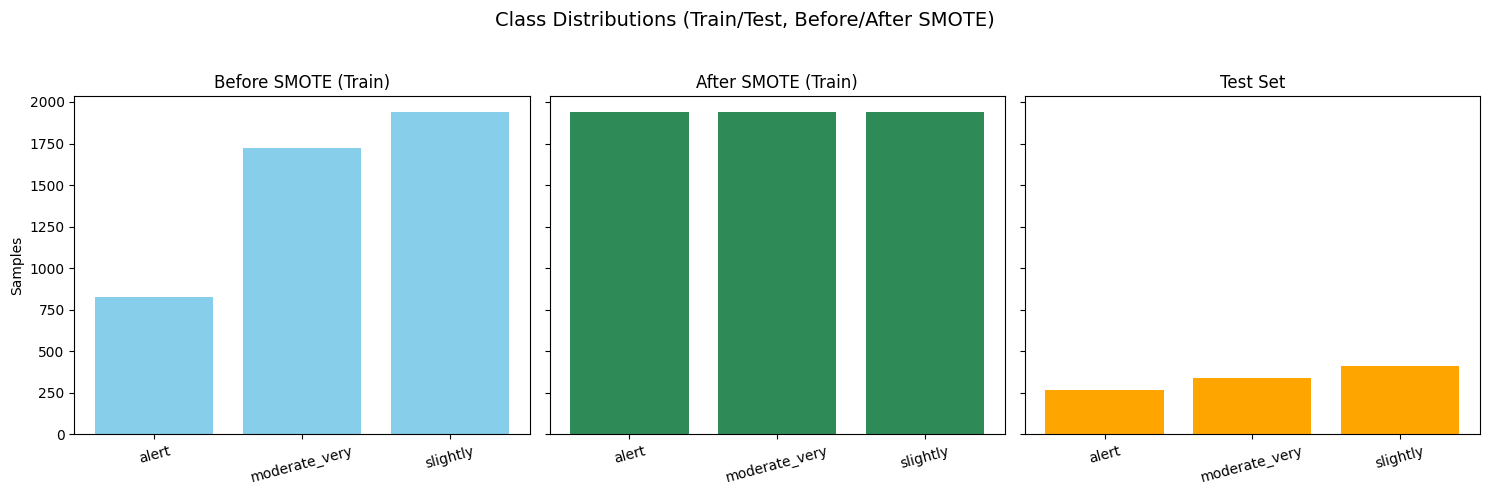

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# --- Load datasets ---
# train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
# test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_noOverlap.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data_noOverlap.csv')

# --- Map and clean labels ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Extract features and labels ---
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode string labels to integers ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Class distribution BEFORE SMOTE ---
print("📊 Class distribution in training set BEFORE SMOTE:")
before_counts = y_train.value_counts()
for label, count in before_counts.items():
    print(f"  {label}: {count} samples")

# --- Class distribution in TEST set ---
print("\n📊 Class distribution in test set:")
test_counts = y_test.value_counts()
for label, count in test_counts.items():
    print(f"  {label}: {count} samples")

# --- Apply SMOTE ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Class distribution AFTER SMOTE ---
y_train_labels_sm = le.inverse_transform(y_train_sm)
after_counts = pd.Series(y_train_labels_sm).value_counts()

print("\n📊 Class distribution in training set AFTER SMOTE:")
for label, count in after_counts.items():
    print(f"  {label}: {count} samples")

# --- Custom label order (if you want consistent axis order) ---
all_labels = sorted(set(before_counts.index).union(after_counts.index).union(test_counts.index))

# --- Reindex for plotting ---
before_counts = before_counts.reindex(all_labels, fill_value=0)
after_counts = after_counts.reindex(all_labels, fill_value=0)
test_counts = test_counts.reindex(all_labels, fill_value=0)

# --- Plot 1×3 comparison ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Before SMOTE
axes[0].bar(before_counts.index, before_counts.values, color='skyblue')
axes[0].set_title("Before SMOTE (Train)")
axes[0].set_ylabel("Samples")
axes[0].tick_params(axis='x', rotation=15)

# After SMOTE
axes[1].bar(after_counts.index, after_counts.values, color='seagreen')
axes[1].set_title("After SMOTE (Train)")
axes[1].tick_params(axis='x', rotation=15)

# Test Set
axes[2].bar(test_counts.index, test_counts.values, color='orange')
axes[2].set_title("Test Set")
axes[2].tick_params(axis='x', rotation=15)

plt.suptitle("Class Distributions (Train/Test, Before/After SMOTE)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Dummy Classifier:

               precision    recall  f1-score   support

        alert       0.27      0.19      0.22       269
     slightly       0.38      0.41      0.39       412
moderate_very       0.34      0.40      0.37       339

     accuracy                           0.35      1020
    macro avg       0.33      0.33      0.33      1020
 weighted avg       0.34      0.35      0.34      1020



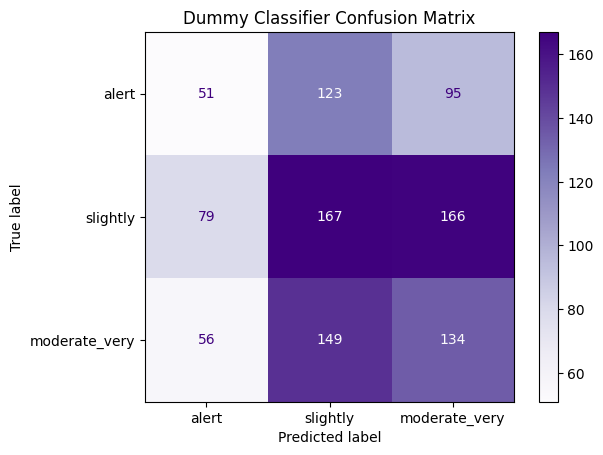

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load CSVs
# train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
# test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_noOverlap.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data_noOverlap.csv')

# Apply mapping
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

# Drop rows with unmapped labels
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# Feature list
features = [col for col in train_df.columns if col != 'Label']

# Extract features and labels
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Fit dummy classifier
dummy_clf = DummyClassifier(strategy='stratified')  
dummy_clf.fit(X_train, y_train_enc)

# Predict
y_pred_dummy = dummy_clf.predict(X_test)

# Define custom order
custom_order = ['alert', 'slightly', 'moderate_very']  # Adjust based on your actual labels
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# Classification report
print("Dummy Classifier:\n")
print(classification_report(
    y_test_enc,
    y_pred_dummy,
    labels=custom_label_indices,
    target_names=custom_order
))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_dummy,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Purples'
)
plt.title("Dummy Classifier Confusion Matrix")
plt.show()

Random Forest:

               precision    recall  f1-score   support

        alert       0.47      0.16      0.24       269
     slightly       0.52      0.63      0.57       412
moderate_very       0.59      0.75      0.66       339

     accuracy                           0.55      1020
    macro avg       0.53      0.51      0.49      1020
 weighted avg       0.53      0.55      0.51      1020

Balanced F1 Score (macro): 0.4894
Balanced F1 Score (weighted): 0.5124
ROC AUC: 0.7330


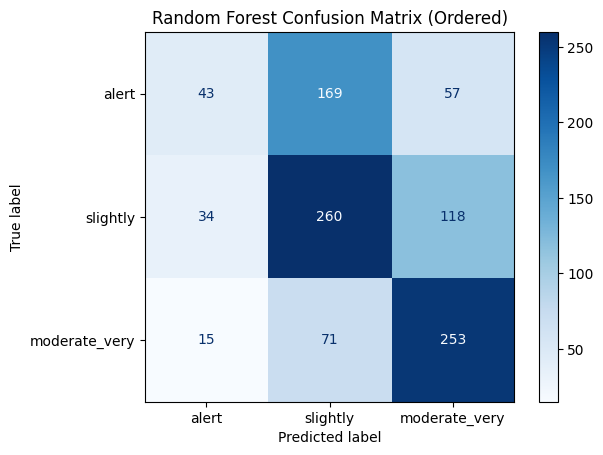

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

# --- Load datasets ---
# train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
# test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_noOverlap.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data_noOverlap.csv')

# --- Map and clean labels ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Remove non-feature columns ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

# --- Split features and labels ---
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Balance training set with SMOTE ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Train Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_sm, y_train_sm)

# --- Predict ---
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # ✅ probability of positive class

# --- Define custom label order ---
custom_order = ['alert', 'slightly', 'moderate_very']  # Adjust based on your actual labels
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# --- Classification report ---
print("Random Forest:\n")
print(classification_report(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    target_names=custom_order
))

# --- Balanced F1 Score ---
f1_macro = f1_score(y_test_enc, y_pred_rf, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_rf, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# --- ROC AUC ---
unique_labels = np.unique(y_test_enc)

if len(unique_labels) == 2:
    # Binary classification → use 1D positive-class probabilities
    auc_score = roc_auc_score(y_test_enc, y_proba_rf)
else:
    # Multi-class (fallback) → use macro OVR strategy
    auc_score = roc_auc_score(y_test_enc, rf_model.predict_proba(X_test),
                              multi_class='ovr', average='macro')

print(f"ROC AUC: {auc_score:.4f}")

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Blues'
)
plt.title("Random Forest Confusion Matrix (Ordered)")
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost:

               precision    recall  f1-score   support

        alert       0.43      0.24      0.31       269
     slightly       0.52      0.60      0.56       412
moderate_very       0.62      0.71      0.66       339

     accuracy                           0.54      1020
    macro avg       0.52      0.52      0.51      1020
 weighted avg       0.53      0.54      0.53      1020

Balanced F1 Score (macro): 0.5076
Balanced F1 Score (weighted): 0.5250
ROC AUC: 0.7202


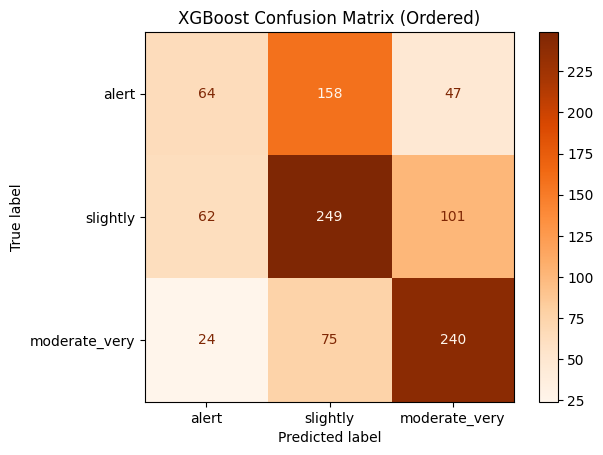

In [125]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

# --- Load datasets ---
# train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data.csv')
# test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data.csv')
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_noOverlap.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data_noOverlap.csv')

# --- Map and clean labels ---
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# --- Remove non-feature columns ---
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

# --- Split features and labels ---
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# --- Encode labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Balance training set with SMOTE ---
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

# --- Train XGBoost ---
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_sm, y_train_sm)

# --- Predict ---
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # ✅ prob for positive class

# --- Define custom label order ---
custom_order = ['alert', 'slightly', 'moderate_very']  # Adjust based on your actual labels
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# --- Classification report ---
print("XGBoost:\n")
print(classification_report(
    y_test_enc,
    y_pred_xgb,
    labels=custom_label_indices,
    target_names=custom_order
))

# --- Balanced F1 Score ---
f1_macro = f1_score(y_test_enc, y_pred_xgb, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_xgb, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# --- ROC AUC ---
unique_labels = np.unique(y_test_enc)

if len(unique_labels) == 2:
    # Binary classification → use 1D positive-class probabilities
    auc_score = roc_auc_score(y_test_enc, y_proba_xgb)
else:
    # Multi-class (fallback) → use macro OVR strategy
    auc_score = roc_auc_score(y_test_enc, xgb_model.predict_proba(X_test),
                              multi_class='ovr', average='macro')

print(f"ROC AUC: {auc_score:.4f}")

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_xgb,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Oranges'
)
plt.title("XGBoost Confusion Matrix (Ordered)")
plt.show()

Iteration 1, loss = 10.09971520
Validation score: 0.314655
Iteration 2, loss = 1.87568490
Validation score: 0.406250
Iteration 3, loss = 1.18600062
Validation score: 0.487069
Iteration 4, loss = 1.10793938
Validation score: 0.442888
Iteration 5, loss = 1.06021617
Validation score: 0.496767
Iteration 6, loss = 1.05444712
Validation score: 0.470905
Iteration 7, loss = 0.99289041
Validation score: 0.523707
Iteration 8, loss = 1.00525140
Validation score: 0.523707
Iteration 9, loss = 0.98945267
Validation score: 0.507543
Iteration 10, loss = 0.96898092
Validation score: 0.561422
Iteration 11, loss = 0.93148566
Validation score: 0.581897
Iteration 12, loss = 1.04549950
Validation score: 0.553879
Iteration 13, loss = 0.97308008
Validation score: 0.577586
Iteration 14, loss = 0.92849653
Validation score: 0.490302
Iteration 15, loss = 0.99748254
Validation score: 0.504310
Iteration 16, loss = 1.00203429
Validation score: 0.579741
Iteration 17, loss = 0.91648342
Validation score: 0.581897
Itera

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


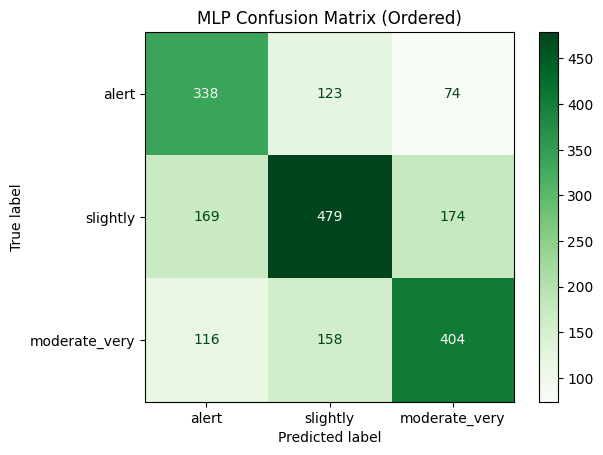

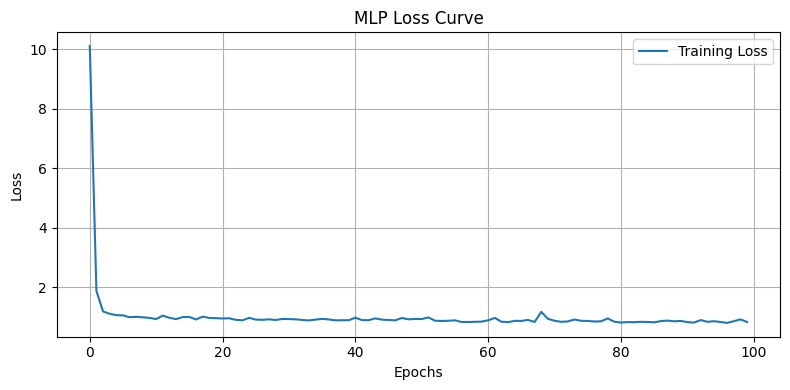

In [132]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
import matplotlib.pyplot as plt

# --- Create validation split from SMOTE-balanced train set ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_sm, y_train_sm, test_size=0.2, random_state=42, stratify=y_train_sm
)

# --- Define MLP model ---
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=100,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)

# --- Fit ---
mlp.fit(X_tr, y_tr)

# --- Predict on test ---
y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]  # ✅ prob of positive class

# --- Custom label order ---
custom_order = ['alert', 'slightly', 'moderate_very']  # Adjust based on your actual labels
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# --- Classification report ---
print("MLP:\n")
print(classification_report(
    y_test_enc,
    y_pred_mlp,
    labels=custom_label_indices,
    target_names=custom_order
))

# --- Balanced F1 Score ---
f1_macro = f1_score(y_test_enc, y_pred_mlp, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_mlp, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# --- ROC AUC ---
unique_labels = np.unique(y_test_enc)

if len(unique_labels) == 2:
    # Binary classification → use 1D positive-class probabilities
    auc_score = roc_auc_score(y_test_enc, y_proba_mlp)
else:
    # Multi-class (fallback) → use macro OVR strategy
    auc_score = roc_auc_score(y_test_enc, mlp.predict_proba(X_test),
                              multi_class='ovr', average='macro')

print(f"ROC AUC: {auc_score:.4f}")

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_mlp,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Greens'
)
plt.title("MLP Confusion Matrix (Ordered)")
plt.show()

# --- Loss curve ---
plt.figure(figsize=(8, 4))
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


L1 Logistic Regression:

               precision    recall  f1-score   support

        alert       0.40      0.41      0.40       269
     slightly       0.57      0.51      0.54       412
moderate_very       0.55      0.60      0.57       339

     accuracy                           0.52      1020
    macro avg       0.51      0.51      0.51      1020
 weighted avg       0.52      0.52      0.52      1020

Balanced F1 Score (macro): 0.5058
Balanced F1 Score (weighted): 0.5154
ROC AUC: 0.6890


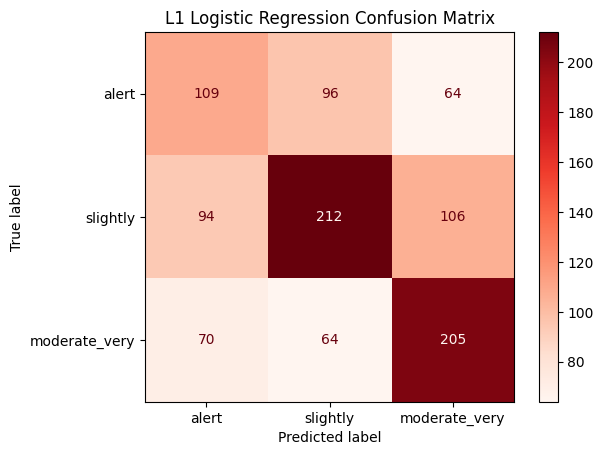

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
import numpy as np
import matplotlib.pyplot as plt

# --- L1 Logistic Regression ---
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
logreg_l1.fit(X_train_sm, y_train_sm)

# --- Predict & Probabilities ---
y_pred_l1 = logreg_l1.predict(X_test)
y_proba_l1 = logreg_l1.predict_proba(X_test)

# --- Binary vs multiclass AUC ---
unique_labels = np.unique(y_test_enc)
if len(unique_labels) == 2:
    auc_score_l1 = roc_auc_score(y_test_enc, y_proba_l1[:, 1])
else:
    auc_score_l1 = roc_auc_score(y_test_enc, y_proba_l1, multi_class='ovr', average='macro')

# --- Classification output ---
custom_order = ['alert', 'slightly', 'moderate_very']  # Adjust based on your actual labels
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

print("L1 Logistic Regression:\n")
print(classification_report(
    y_test_enc,
    y_pred_l1,
    labels=custom_label_indices,
    target_names=custom_order
))

f1_macro = f1_score(y_test_enc, y_pred_l1, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_l1, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")
print(f"ROC AUC: {auc_score_l1:.4f}")

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_l1,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Reds'
)
plt.title("L1 Logistic Regression Confusion Matrix")
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


L2 Logistic Regression:

               precision    recall  f1-score   support

        alert       0.40      0.40      0.40       269
     slightly       0.55      0.51      0.53       412
moderate_very       0.57      0.63      0.60       339

     accuracy                           0.52      1020
    macro avg       0.51      0.51      0.51      1020
 weighted avg       0.52      0.52      0.52      1020

Balanced F1 Score (macro): 0.5114
Balanced F1 Score (weighted): 0.5205
ROC AUC: 0.7159


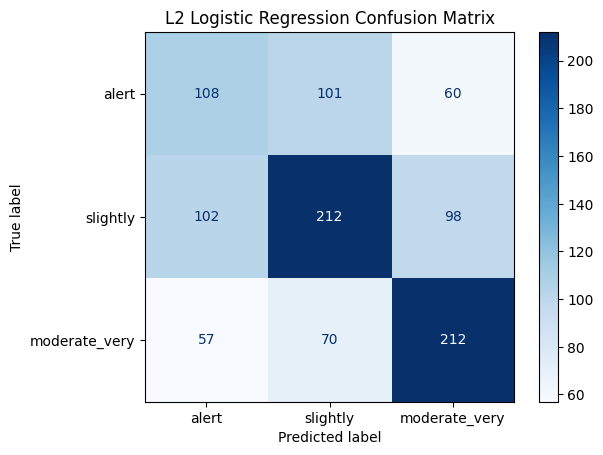

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
import numpy as np
import matplotlib.pyplot as plt

# --- L2 Logistic Regression ---
logreg_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
logreg_l2.fit(X_train_sm, y_train_sm)

# --- Predict & Probabilities ---
y_pred_l2 = logreg_l2.predict(X_test)
y_proba_l2 = logreg_l2.predict_proba(X_test)

# --- Binary vs multiclass AUC ---
unique_labels = np.unique(y_test_enc)
if len(unique_labels) == 2:
    auc_score_l2 = roc_auc_score(y_test_enc, y_proba_l2[:, 1])
else:
    auc_score_l2 = roc_auc_score(y_test_enc, y_proba_l2, multi_class='ovr', average='macro')

# --- Classification output ---
print("L2 Logistic Regression:\n")
print(classification_report(
    y_test_enc,
    y_pred_l2,
    labels=custom_label_indices,
    target_names=custom_order
))

f1_macro = f1_score(y_test_enc, y_pred_l2, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_l2, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")
print(f"ROC AUC: {auc_score_l2:.4f}")

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_l2,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Blues'
)
plt.title("L2 Logistic Regression Confusion Matrix")
plt.show()

Elastic Net Logistic Regression:

               precision    recall  f1-score   support

        alert       0.51      0.38      0.43       269
     slightly       0.60      0.38      0.46       412
moderate_very       0.51      0.84      0.63       339

     accuracy                           0.53      1020
    macro avg       0.54      0.53      0.51      1020
 weighted avg       0.55      0.53      0.51      1020

Balanced F1 Score (macro): 0.5101
Balanced F1 Score (weighted): 0.5119
ROC AUC: 0.7184


/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


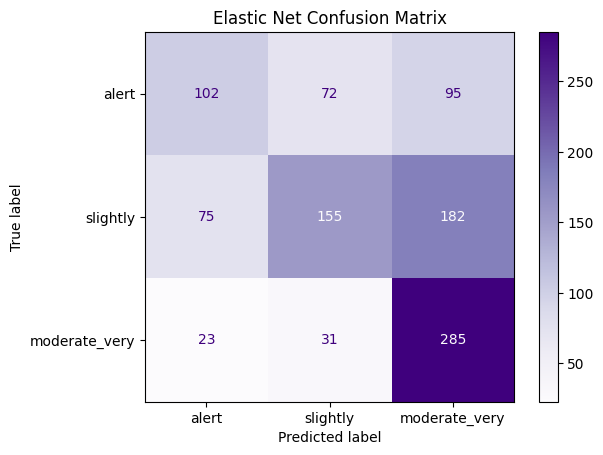

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
import numpy as np
import matplotlib.pyplot as plt

# --- Elastic Net Logistic Regression ---
logreg_en = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    max_iter=1000,
    random_state=42
)
logreg_en.fit(X_train_sm, y_train_sm)

# --- Predict & Probabilities ---
y_pred_en = logreg_en.predict(X_test)
y_proba_en = logreg_en.predict_proba(X_test)

# --- Binary vs multiclass AUC ---
unique_labels = np.unique(y_test_enc)
if len(unique_labels) == 2:
    auc_score_en = roc_auc_score(y_test_enc, y_proba_en[:, 1])
else:
    auc_score_en = roc_auc_score(y_test_enc, y_proba_en, multi_class='ovr', average='macro')

# --- Custom label ordering ---
custom_order = ['alert', 'slightly', 'moderate_very']
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# --- Report ---
print("Elastic Net Logistic Regression:\n")
print(classification_report(
    y_test_enc,
    y_pred_en,
    labels=custom_label_indices,
    target_names=custom_order
))

f1_macro = f1_score(y_test_enc, y_pred_en, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_en, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")
print(f"ROC AUC: {auc_score_en:.4f}")

# --- Confusion matrix ---
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_en,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Purples'
)
plt.title("Elastic Net Confusion Matrix")
plt.show()